In [14]:
%cd ./..
import sys
from dataset import *
from trainer import Trainer
from ezdict import EZDict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
import matplotlib
import pandas as pd
from sklearn.feature_selection import mutual_info_regression as MIR

/media/hdd10tb/yingxic4/SAILER


In [2]:
def get_cmap(n, name='tab10'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(10)

## Data Files
Files are named after simulation setting, signal to noise ratio and mean number of peaks per cell. Data are stored as sparse matrices in npz files. Cell labels are in txt files.

In [3]:
!ls ./data/SimATAC

setting2_s0.35_f3000.SCAN-ATAC-Sim_labels.txt
setting2_s0.35_f3000.SCAN-ATAC-Sim.npz
setting2_s0.4_f3000.SCAN-ATAC-Sim_labels.txt
setting2_s0.4_f3000.SCAN-ATAC-Sim.npz
setting2_s0.4_f5000.SCAN-ATAC-Sim_labels.txt
setting2_s0.4_f5000.SCAN-ATAC-Sim.npz


## Training

In [4]:
args = EZDict({
    "name": 'sim1_z10',
    'log': 'train_log.csv',
    'load_ckpt': False, 
    'cuda_dev': [2], #False
    'sample_batch': False,
    "max_epoch": 400,
    'start_epoch': 1,
    'batch_size': 100,
    'start_save': 290,
    'LAMBDA': 1,
    'conv': False,
    'model_type': 'inv',
    'data_type': 'simATAC',
    'lr': 1e-3, 
    'pos_w': 20,
    'weight_decay': 5e-4,
    'optimizer': 'adam',
    'z_dim': 10,
    'out_every': 5,
    'ckpt_dir': './models/',
    #simATAC
    'setting': 2,
    'signal': 0.4,
    'frags': 5000,
    'bin_size': 10000,
    #ATACbenchmark
    'cov': 1000
})

In [5]:
solver = Trainer(args)

Using cuda
Finish loading in 2.393421173095703, data size (10000, 90635)


In [6]:
solver.warm_up()

100%|██████████| 10/10 [03:20<00:00, 20.10s/it]

[Warmup Finished]


In [7]:
solver.inv_train()

  0%|          | 0/399 [00:00<?, ?it/s]

Inv Training started


400it [2:16:44, 20.51s/it]                           

[Inv Training Finished]


## Cyclical Annealing Schedule

See [here](https://www.microsoft.com/en-us/research/blog/less-pain-more-gain-a-simple-method-for-vae-training-with-less-of-that-kl-vanishing-agony/) for a blog on how to deal with kl vanishing.
![image](https://www.microsoft.com/en-us/research/uploads/prod/2019/04/equation.png)

### (a) monotonic schedule vs (b) the cyclical schedule
![image](https://www.microsoft.com/en-us/research/uploads/prod/2019/04/Annealing-with-the-monotonic-schedule-768x498.png)
### Example results
![image](https://www.microsoft.com/en-us/research/uploads/prod/2019/04/figure-4-1.png)
![image](https://www.microsoft.com/en-us/research/uploads/prod/2019/04/figure-4.png)

## Traing log

In [19]:
log = pd.read_csv('models/sim1_z10/invtrain_log.csv')

In [20]:
log

,iter,kl,bce
0,1,629.834875,41422867.52
1,2,777.478199,37485190.48
2,3,758.818616,37348211.68
3,4,769.022310,37100330.16
4,5,837.630695,37022924.12
...,...,...,...
395,396,2471.484248,34430445.08
396,397,2474.495210,34427021.68
397,398,2483.564548,34419971.86
398,399,2475.013413,34413601.96


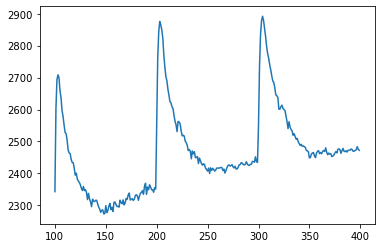

In [35]:
plt.plot(log.kl[100:])

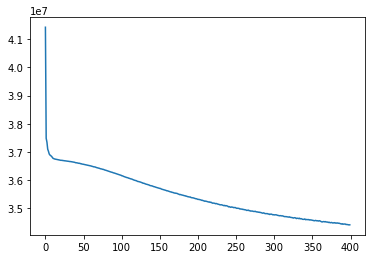

In [36]:
plt.plot(log.bce)

## Visualize latent embedding
Visualize latent embedding of cells with UMAP. Cells are colored by ground truth cell types.

In [8]:
latent, labels, depth = solver.encode_adv()

10it [00:17,  1.72s/it]


In [9]:
result = latent.numpy()

In [10]:
l = pd.DataFrame(labels, columns=['celltype'])

In [11]:
reducer = umap.UMAP(random_state=123)
X_embedded = reducer.fit_transform(result)

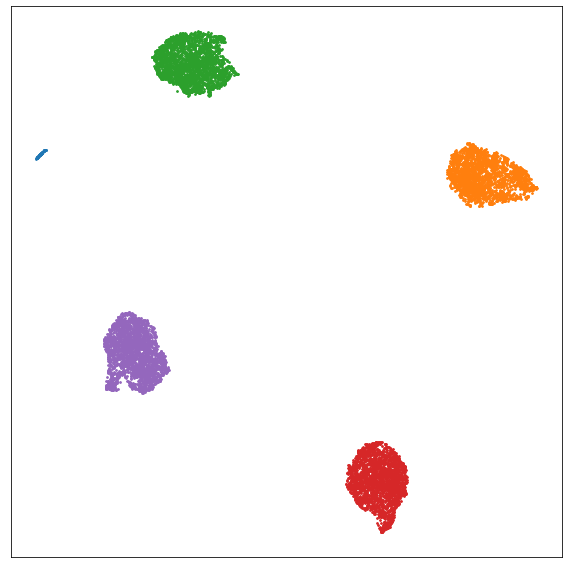

In [12]:
plt.figure(figsize=(8, 8))
for i, c in enumerate(np.unique(l)):
    mask = (l == c).values.flatten()
    plt.scatter(X_embedded[mask, 0], X_embedded[mask, 1], label=c, s=3, color=cmap(i))
    plt.xticks([], [])
    plt.yticks([], [])
plt.tight_layout()

## Visualize depth distribution on latent embedding

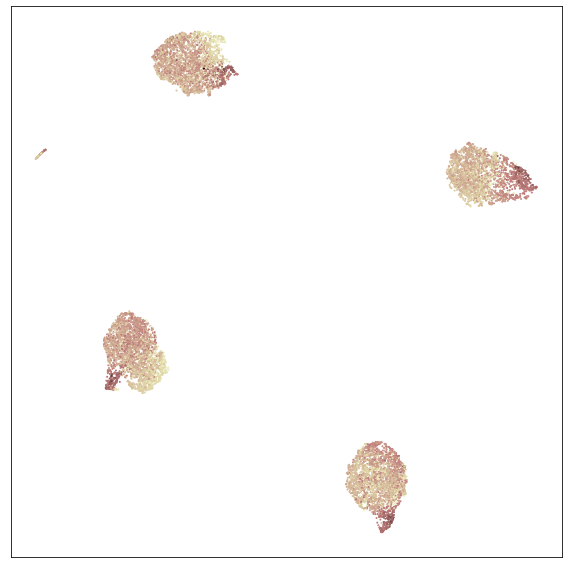

In [28]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(X_embedded[:, 0], 
            X_embedded[:, 1], 
            s=1, 
            c=np.array(depth),
            norm=matplotlib.colors.LogNorm(),
            cmap='pink'
            )
plt.xticks([], [])
plt.yticks([], [])
cbar = plt.colorbar()
cbar.remove()
plt.tight_layout()

## Mutual Information
Caculate mean mutual information between latent embedding and read depth.

In [32]:
mi = MIR(result, depth)
print(mi.mean())

0.07285391324362153
